# Initialization

In [1]:
# Устанавливается необходимая версия пакетов для воспроизводимости экспирементов
# А так же для установки всех недостающих зависимостей

'''Windows'''
#!python -m venv venv
#!.\venv\Scripts\activate
#!pip install -r requirements.txt

'''Linux''';
#!python -m venv venv  
#!source ./venv/bin/activate  
#!pip install -r requirements.txt

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

In [3]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]
Numpy        : 1.22.2


In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
# !pip freeze > requirements.txt

In [5]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# functions

In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

### Data

In [7]:
from pathlib import Path  
train = pd.read_csv(Path("data", "all_auto_ru_09_09_2020.csv"))
test = pd.read_csv(Path('data', 'test.csv'))

### EDA

##### Предварительное сравнение TRAIN и TEST

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [10]:
print('TRAIN','Rows =', np.shape(train)[0],'Columns =', np.shape(train)[1], sep=' ')
print('TEST ','Rows =', np.shape(test)[0],'Columns =', np.shape(test)[1], sep=' ') 

TRAIN Rows = 89378 Columns = 26
TEST  Rows = 34686 Columns = 32


Даже простое сравнение по размеру матриц TRAIN и TEST говорит о том, что они не совпадают.

Анализ типа и содержания данных в столбце позволит сделать предварительную обработку (представить данные в едином формате), а также ответить на вопрос, есть ли общие данные в несовпадающих (предположительно, по названию) столбцах TRAIN и TEST.

In [11]:
#Удаление дублирующихся строк
train_mod = train.drop_duplicates()
test_mod = test.drop_duplicates()

print('TRAIN','Rows =', np.shape(train_mod)[0],'Columns =', np.shape(train_mod)[1], sep=' ')
print('TEST ','Rows =', np.shape(test_mod)[0],'Columns =', np.shape(test_mod)[1], sep=' ') 

TRAIN Rows = 87264 Columns = 26
TEST  Rows = 34686 Columns = 32


Сравнение размера матриц до и после удаления дубликатов показывает, что TRAIN были дублирующиеся строки, теперь их нет.

##### Определение общих и различающихся столбцов в TRAIN и TEST

In [12]:
#Общие столбцы
common_columns = set(test.columns).intersection(train.columns)

#Только в TEST
test_only_columns = set(test.columns).difference(train.columns)

#Только в TRAIN
train_only_columns = set(train.columns).difference(test.columns)

#### Вопросы для дальнейшего анализа:
1. Совпадают ли типы данных в общих столбцах?
2. Есть ли сходные по содержанию данные в столбцах с разным названием?
3. Есть ли столбцы, которые можно удалить?

##### Общие столбцы TRAIN и TEST - сравнение данных

In [13]:
#Датафрейм со сравнением типов данных
index_list = test[common_columns].dtypes.index.to_list()
test_list = test[common_columns].dtypes.values.tolist()
train_list = train[common_columns].dtypes.values.tolist()

dict_comparison = {
    'title': index_list,
    'test_type': test_list,
    'train_type': train_list
}

comparison = pd.DataFrame(dict_comparison)
comparison.sort_values('title')

C:\Users\zetet\AppData\Local\Temp\ipykernel_14240\3298209608.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  index_list = test[common_columns].dtypes.index.to_list()
C:\Users\zetet\AppData\Local\Temp\ipykernel_14240\3298209608.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  test_list = test[common_columns].dtypes.values.tolist()
C:\Users\zetet\AppData\Local\Temp\ipykernel_14240\3298209608.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_list = train[common_columns].dtypes.values.tolist()


,title,test_type,train_type
20,bodyType,object,object
10,brand,object,object
16,color,object,object
2,description,object,object
1,engineDisplacement,object,object
13,enginePower,object,float64
15,fuelType,object,object
17,mileage,int64,int64
14,modelDate,int64,float64
0,name,object,object


Как можно видеть, формат данных в части столбцов с одинаковыми названиями не совпадает. Также необходимо исследовать содержаимое ячеек.

##### Бренды в TRAIN и TEST

In [14]:
display(train_mod.brand.unique())
print('Всего в TRAIN',len(train.brand.unique()),'брендов.',sep=' ')

array(['AUDI', 'BMW', 'CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER',
       'CITROEN', 'DAEWOO', 'DODGE', 'FORD', 'GEELY', 'HONDA', 'HYUNDAI',
       'INFINITI', 'JAGUAR', 'JEEP', 'KIA', 'LEXUS', 'MAZDA', 'MINI',
       'MITSUBISHI', 'NISSAN', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT',
       'SKODA', 'SUBARU', 'SUZUKI', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO',
       'GREAT_WALL', 'LAND_ROVER', 'MERCEDES', 'SSANG_YONG'], dtype=object)

Всего в TRAIN 36 брендов.


In [15]:
display(test_mod.brand.unique())
print('Всего в TEST',len(test_mod.brand.unique()),'брендов.',sep=' ')

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

Всего в TEST 12 брендов.


Мы видим, что в TRAIN представлено в 3 раза больше брендов автомобилей. Посмотрим на их распределение в обоих датасетах.

Text(0.5, 1.0, 'TEST brands')

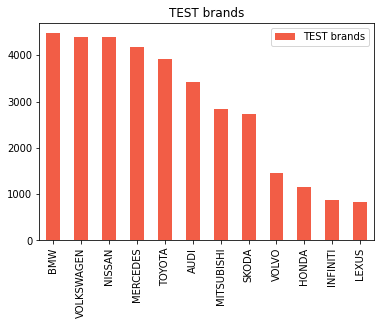

In [16]:
#Распределение брендов в TEST
test_mod['brand'].value_counts().plot(kind='bar', color = '#F25D46', label='TEST brands')
plt.legend()
plt.title('TEST brands')

Text(0.5, 1.0, 'TRAIN brands')

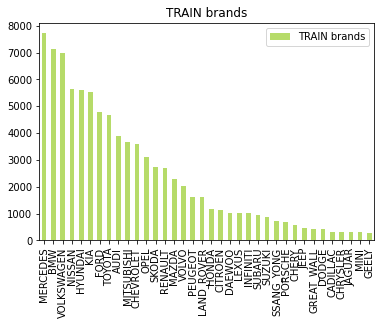

In [17]:
#Распределение брендов в TRAIN
train_mod['brand'].value_counts().plot(kind='bar', color = '#B6DB69', label='TRAIN brands')
plt.legend()
plt.title('TRAIN brands')

Мы видим, что распеределение брендов, представленных только во TEST, схоже с TRAIN. 

Поэтому для базовой модели ML отсутствующие модели можно удалить, однако для Staking и ансамблей можно попробовать объединить присутствующие и удаленные модели в классы для извлечения новых признаков.

Text(0.5, 1.0, 'MOD_TRAIN brands')

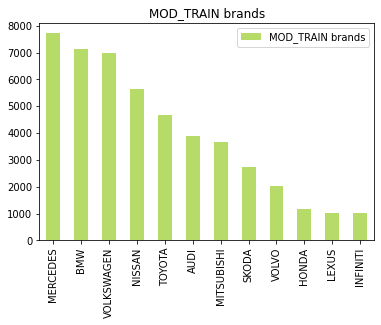

In [18]:
#Удаление отсутствующих в TEST брендов
#Список брендов из TEST
brand_list = test_mod.brand.unique().tolist()
train_mod = train_mod.loc[train.brand.isin(brand_list)]

#Распределение брендов в модифицированном TRAIN
train_mod['brand'].value_counts().plot(kind='bar', color = '#B6DB69', label='MOD_TRAIN brands')
plt.legend()
plt.title('MOD_TRAIN brands')

##### Сравнение содержание ячеек TRAIN и TEST, приведение к единому формату

In [19]:
#Датафрейм со сравнением типов данных
index_list = test[common_columns].dtypes.index.to_list()
test_list = test[common_columns].dtypes.values.tolist()
train_list = train[common_columns].dtypes.values.tolist()

dict_comparison = {
    'title': index_list,
    'test_type': test_list,
    'train_type': train_list
}

comparison = pd.DataFrame(dict_comparison)
comparison.sort_values('title')

C:\Users\zetet\AppData\Local\Temp\ipykernel_14240\3298209608.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  index_list = test[common_columns].dtypes.index.to_list()
C:\Users\zetet\AppData\Local\Temp\ipykernel_14240\3298209608.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  test_list = test[common_columns].dtypes.values.tolist()
C:\Users\zetet\AppData\Local\Temp\ipykernel_14240\3298209608.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_list = train[common_columns].dtypes.values.tolist()


,title,test_type,train_type
20,bodyType,object,object
10,brand,object,object
16,color,object,object
2,description,object,object
1,engineDisplacement,object,object
13,enginePower,object,float64
15,fuelType,object,object
17,mileage,int64,int64
14,modelDate,int64,float64
0,name,object,object


In [20]:
#Функция для просмотра и сравнения типов данных в столбцах
def type_comparison(column):
    print('TEST')
    display(test_mod[column].sample(5))
    print('TRAIN')
    display(train_mod[column].sample(5))  

In [21]:
#bodyType
column = 'bodyType'
type_comparison(column)

TEST


20599    хэтчбек 5 дв.
16904            седан
13801            седан
1378           лифтбек
17876            седан
Name: bodyType, dtype: object

TRAIN


50001                Седан
51279    Внедорожник 5 дв.
31688    Внедорожник 5 дв.
42190    Внедорожник 5 дв.
6819                 Седан
Name: bodyType, dtype: object

In [22]:
#color
column = 'color'
type_comparison(column)

TEST


14800    чёрный
14523    чёрный
6836     чёрный
17563     синий
26783     белый
Name: color, dtype: object

TRAIN


8838     040001
70451    C49648
5859     040001
66905    040001
6070     C49648
Name: color, dtype: object

In [23]:
#description
column = 'description'
type_comparison(column)

TEST


3307     Машина в отличном техническом и внешнем состоя...
11213    Все автомобили, для Вашего удобства, находятся...
32348    Продается личный автомобиль.Полностью обслужен...
14509    2 телевизора,люк,панорамная крыша,максимальная...
27962                             Авто в хорошем состоянии
Name: description, dtype: object

TRAIN


87625    Автомобиль в отличном состоянии,без ДТП,куплен...
81000    Наше предложение удивит Вас! Лучшие условия по...
84585    Эксклюзивные условия в «Звезда Столицы Варшавк...
76790          В хорошем состоянии, подробнее по телефону 
30964    Комплектация: 3.5 AT AWD Elite+NAVI. \n11000 к...
Name: description, dtype: object

In [24]:
#engineDisplacement
column = 'engineDisplacement'
type_comparison(column)

TEST


7392     2.0 LTR
7544     2.0 LTR
8101     3.0 LTR
25665    1.6 LTR
1982     1.8 LTR
Name: engineDisplacement, dtype: object

TRAIN


70475      1.6
62106      1.6
9160       20d
10190    4.6is
1943       2.4
Name: engineDisplacement, dtype: object

In [25]:
#Преобразование
def GetEngineDisplacement(x):
    row = str(x)
    engine = re.findall('\d\.\d', row)
    if engine == []:
        return None
    return float(engine[0])

train_mod['engineDisplacement'] = train_mod['engineDisplacement'].map(GetEngineDisplacement)
test_mod['engineDisplacement'] = test_mod['engineDisplacement'].map(GetEngineDisplacement)

In [26]:
#engineDisplacement
column = 'engineDisplacement'
type_comparison(column)

TEST


10480    2.0
17374    3.5
3813     1.8
12011    2.5
26905    3.8
Name: engineDisplacement, dtype: float64

TRAIN


46137    1.6
2191     3.1
10986    NaN
62703    1.2
49387    2.0
Name: engineDisplacement, dtype: float64

In [27]:
#enginePower
column = 'enginePower'
type_comparison(column)

TEST


11760    158 N12
8106     507 N12
27298    170 N12
31126    150 N12
2410     245 N12
Name: enginePower, dtype: object

TRAIN


60664    152.0
76341    174.0
75959    249.0
6366     184.0
72579    115.0
Name: enginePower, dtype: float64

In [28]:
#Преобразование
train_mod.enginePower = train_mod.enginePower.convert_dtypes(int)
test_mod["enginePower"] = test_mod["enginePower"].apply(lambda x : (int)(x.split(' ')[0]))

In [29]:
#enginePower
column = 'enginePower'
type_comparison(column)

TEST


14522    116
26783    117
25347     85
28676    200
1866     105
Name: enginePower, dtype: int64

TRAIN


49554    141
81372    150
2562     245
68879    149
3113     249
Name: enginePower, dtype: Int64

In [30]:
#fuelType
column = 'fuelType'
type_comparison(column)

TEST


68       бензин
6964     дизель
9092     бензин
12852    бензин
10535    бензин
Name: fuelType, dtype: object

TRAIN


39080    бензин
3996     бензин
49342    бензин
88459    дизель
6182     бензин
Name: fuelType, dtype: object

In [31]:
train_mod.fuelType.unique() # универсал выбросить, есть один пропуск, выбросить

array(['бензин', 'дизель', 'электро', 'гибрид', 'универсал', 'газ'],
      dtype=object)

In [32]:
test_mod.fuelType.unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ'], dtype=object)

In [33]:
#mileage
column = 'mileage'
type_comparison(column)

TEST


9464     186000
21069    271587
12877    293000
28352    186000
8748     135000
Name: mileage, dtype: int64

TRAIN


68802         0
8677     154639
10136    225000
1531     137000
69053         0
Name: mileage, dtype: int64

In [34]:
#modelDate
column = 'modelDate'
type_comparison(column) # model year на самом деле

TEST


25013    2008
27869    2007
1115     2013
27441    2006
31857    2002
Name: modelDate, dtype: int64

TRAIN


5688     2015.0
49762    2014.0
10863    2007.0
8079     2012.0
5763     2018.0
Name: modelDate, dtype: float64

In [35]:
#Преобразование
train_mod.modelDate = train_mod.modelDate.convert_dtypes(int) #astype('int')

In [36]:
#name
column = 'name'
type_comparison(column) # ЧТо-то лежит

TEST


20103         2.0 MT (200 л.с.)
16872     250 1.8 AT (204 л.с.)
30549         1.6 MT (110 л.с.)
13051        2.0 CVT (141 л.с.)
18453    220 2.2d AT (150 л.с.)
Name: name, dtype: object

TRAIN


42085                   2.0 AT (240 л.с.) 4WD
74016                       1.6 MT (105 л.с.)
81610    180 BlueEFFICIENCY 1.8 AT (156 л.с.)
42598                       2.5 AT (163 л.с.)
48722                      2.0 CVT (141 л.с.)
Name: name, dtype: object

In [37]:
#numberOfDoors
column = 'numberOfDoors'
type_comparison(column)

TEST


1249     5
28703    5
31808    4
2470     5
22105    5
Name: numberOfDoors, dtype: int64

TRAIN


50212    5.0
81480    4.0
85092    5.0
24785    5.0
11202    5.0
Name: numberOfDoors, dtype: float64

In [38]:
#Преобразование
train_mod.numberOfDoors = train_mod.numberOfDoors.convert_dtypes(int)

In [39]:
#productionDate # дата производства, есть ещё дата модели
column = 'productionDate'
type_comparison(column)

TEST


19685    1992
34549    2012
28594    2013
26893    2007
31083    2019
Name: productionDate, dtype: int64

TRAIN


61373    2017
47114    2011
87211    2014
4829     2013
10251    2020
Name: productionDate, dtype: int64

In [40]:
#vehicleConfiguration
column = 'vehicleConfiguration'
type_comparison(column)

TEST


16540    ALLROAD_5_DOORS AUTOMATIC 3.0
21616         COMPACTVAN AUTOMATIC 2.2
10251    ALLROAD_5_DOORS AUTOMATIC 4.4
17546    ALLROAD_5_DOORS AUTOMATIC 5.5
31853    ALLROAD_5_DOORS AUTOMATIC 4.7
Name: vehicleConfiguration, dtype: object

TRAIN


61427           LIFTBACK AUTOMATIC 1.8
74896    ALLROAD_5_DOORS AUTOMATIC 2.0
49174     ALLROAD_5_DOORS VARIATOR 2.0
83283              SEDAN AUTOMATIC 200
25160       WAGON_5_DOORS ROBOT 1.5hyb
Name: vehicleConfiguration, dtype: object

In [41]:
#vehicleTransmission
column = 'vehicleTransmission'
type_comparison(column)

TEST


32131    автоматическая
4688           вариатор
8802     автоматическая
11579          вариатор
4423     автоматическая
Name: vehicleTransmission, dtype: object

TRAIN


8894      AUTOMATIC
8111      AUTOMATIC
25135    MECHANICAL
48413    MECHANICAL
82635     AUTOMATIC
Name: vehicleTransmission, dtype: object

In [42]:
#Преобразование
train_mod.vehicleTransmission.unique()

array(['MECHANICAL', 'AUTOMATIC', 'ROBOT', 'VARIATOR', nan], dtype=object)

In [43]:
test_mod.vehicleTransmission.unique()

array(['роботизированная', 'механическая', 'автоматическая', 'вариатор'],
      dtype=object)

In [44]:
test_mod = test_mod.replace({'vehicleTransmission':
                            {'автоматическая': 'AUTOMATIC',
                            'вариатор': 'VARIATOR',
                            'механическая': 'MECHANICAL',
                            'роботизированная': 'ROBOT'}})

In [45]:
#Владельцы
column = 'Владельцы'
type_comparison(column)

TEST


26686    3 или более
8977     3 или более
8209     3 или более
15673     1 владелец
21556     1 владелец
Name: Владельцы, dtype: object

TRAIN


72515    3.0
81563    3.0
11207    3.0
83449    3.0
7715     NaN
Name: Владельцы, dtype: float64

In [46]:
test_mod.Владельцы.unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object)

In [47]:
#Преобразование
train_mod.Владельцы = train_mod.Владельцы.convert_dtypes(int)

test_mod = test_mod.replace({'Владельцы':
                            {'1\xa0владелец': 1,
                            '2\xa0владельца': 2,
                            '3 или более': 3}})

In [48]:
#Владение
column = 'Владение' # перевести в дни, можно выкинуть
type_comparison(column)

TEST


32655                    NaN
10423                    NaN
21316     4 года и 9 месяцев
22553    4 года и 11 месяцев
16964    4 года и 10 месяцев
Name: Владение, dtype: object

TRAIN


31571    {'year': 2018, 'month': 6}
77829                           NaN
42343                           NaN
25061                           NaN
39117                           NaN
Name: Владение, dtype: object

In [49]:
#Посчитаем % пропусков
col = 'Владение'

pct_missing_1 = np.mean(test[col].isnull()) 
print('TEST')
print('{} - {}%'.format(col, round(pct_missing_1*100)))
pct_missing_2 = np.mean(train_mod[col].isnull()) 
print('TRAIN')
print('{} - {}%'.format(col, round(pct_missing_2*100)))

TEST
Владение - 65%
TRAIN
Владение - 69%


Большой процент пропусков в TRAIN и TEST (около 70%), столбец можно удалить.

In [50]:
#Привод
column = 'Привод'
type_comparison(column)

TEST


14308      полный
8349       полный
8147       задний
12147      полный
32906    передний
Name: Привод, dtype: object

TRAIN


39064      полный
80695    передний
66580      задний
7981       полный
67856      полный
Name: Привод, dtype: object

In [51]:
#ПТС
column = 'ПТС'
type_comparison(column)

TEST


23845    Оригинал
26887    Оригинал
21305    Дубликат
2862     Дубликат
6236     Оригинал
Name: ПТС, dtype: object

TRAIN


3141     ORIGINAL
5891     ORIGINAL
81928    ORIGINAL
65021    ORIGINAL
75428    ORIGINAL
Name: ПТС, dtype: object

In [52]:
#Преобразование
test_mod = test_mod.replace({'ПТС':
                            {'Оригинал': 'ORIGINAL',
                            'Дубликат': 'DUPLICATE'}})

In [53]:
#Руль
column = 'Руль'
type_comparison(column)

TEST


16275    Левый
28629    Левый
19660    Левый
7864     Левый
32657    Левый
Name: Руль, dtype: object

TRAIN


85405     LEFT
45294     LEFT
76363     LEFT
39175     LEFT
66428    RIGHT
Name: Руль, dtype: object

In [54]:
#Преобразование
test_mod = test_mod.replace({'Руль':
                            {'Левый': 'LEFT',
                            'Правый': 'RIGHT'}})

In [55]:
#Состояние # выкинуть
column = 'Состояние'
type_comparison(column)

TEST


5977     Не требует ремонта
15185    Не требует ремонта
26419    Не требует ремонта
24357    Не требует ремонта
25446    Не требует ремонта
Name: Состояние, dtype: object

TRAIN


4397    NaN
45925   NaN
10049   NaN
73178   NaN
45075   NaN
Name: Состояние, dtype: float64

In [56]:
test_mod.Состояние.unique()

array(['Не требует ремонта'], dtype=object)

In [57]:
train_mod.Состояние.unique()

array([nan])

В TEST только одно значение, в TRAIN - пустой столбец. СОСТОЯНИЕ можно удалить.

In [58]:
#Таможня
column = 'Таможня'
type_comparison(column)

TEST


4016     Растаможен
24573    Растаможен
25064    Растаможен
20021    Растаможен
7478     Растаможен
Name: Таможня, dtype: object

TRAIN


290      True
48814    True
46267    True
73523    True
76835    True
Name: Таможня, dtype: bool

In [59]:
test_mod.Таможня.unique()

array(['Растаможен'], dtype=object)

In [60]:
train_mod.Таможня.unique()

array([ True])

В TRAIN и TEST во всех строках одинаковое значение, столбец ТАМОЖНЯ можно удалить.

### Столбцы ТОЛЬКО TEST

In [61]:
test_mod[test_only_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 0 to 34685
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sell_id             34686 non-null  int64 
 1   vendor              34686 non-null  object
 2   image               34686 non-null  object
 3   priceCurrency       34686 non-null  object
 4   model_info          34686 non-null  object
 5   model_name          34686 non-null  object
 6   car_url             34686 non-null  object
 7   equipment_dict      24690 non-null  object
 8   super_gen           34686 non-null  object
 9   parsing_unixtime    34686 non-null  int64 
 10  complectation_dict  6418 non-null   object
dtypes: int64(2), object(9)
memory usage: 3.2+ MB


C:\Users\zetet\AppData\Local\Temp\ipykernel_14240\1526034085.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  test_mod[test_only_columns].info()


In [62]:
#equipment_dict
#Процент пропусков
col = 'equipment_dict'
missing = np.mean(test_mod[col].isnull()) 
print('{} - {}%'.format(col, round(missing*100)))

equipment_dict - 29%


In [63]:
test_mod.equipment_dict.sample(5)

27285    {"cruise-control":true,"tinted-glass":true,"es...
30838                                                  NaN
19821                                                  NaN
18937    {"cruise-control":true,"tinted-glass":true,"es...
10696    {"engine-proof":true,"front-centre-armrest":tr...
Name: equipment_dict, dtype: object

In [64]:
test_mod.equipment_dict[938] # Ментор сказал выкинуть, кек

'{"engine-proof":true,"tinted-glass":true,"esp":true,"airbag-driver":true,"aux":true,"isofix":true,"usb":true,"electro-window-front":true,"hcc":true,"audiopreparation":true,"heated-wash-system":true,"ashtray-and-cigarette-lighter":true,"airbag-passenger":true,"computer":true,"seat-transformation":true,"wheel-power":true,"lock":true,"fabric-seats":true,"electro-mirrors":true,"steel-wheels":true,"rain-sensor":true,"airbag-side":true,"mirrors-heat":true,"driver-seat-updown":true,"condition":true,"led-lights":true,"abs":true,"front-seats-heat":true,"wheel-configuration1":true,"immo":true,"12v-socket":true,"15-inch-wheels":true}'

Данные содержат описание комплектации, могут служить для извлечения дополнительных признаков.

In [65]:
#super_gen можно заменить пропуски
test_mod.super_gen.sample(5)

17947    {"id":"20243371","name":"200","nameplate":"200...
25635    {"id":"4698283","displacement":1595,"engine_ty...
4751     {"id":"21191720","displacement":3697,"engine_t...
17150    {"id":"20092320","name":"300","nameplate":"300...
27908    {"id":"8297113","displacement":1997,"engine_ty...
Name: super_gen, dtype: object

In [66]:
test_mod.super_gen[938]

'{"id":"20105521","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"AUTOMATIC","power":110,"power_kvt":81,"human_name":"1.6 AT (110 л.с.)","acceleration":12.2,"clearance_min":155,"fuel_rate":6.7}'

Данные частично дублируются с vehicleTransmission и engineDisplacement, также могут использоваться для извлечения дополнительных признаков.

In [67]:
#model_info # Выкинуть
test_mod.model_info.sample(5)

22662    {"code":"GS","name":"GS","ru_name":"GS","morph...
27441    {"code":"PAJERO","name":"Pajero","ru_name":"Па...
3088     {"code":"Q3","name":"Q3","ru_name":"Ку3","morp...
305      {"code":"OCTAVIA","name":"Octavia","ru_name":"...
11615    {"code":"TEANA","name":"Teana","ru_name":"Тиан...
Name: model_info, dtype: object

In [68]:
test_mod.model_info[938]

'{"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}'

In [69]:
test_mod.model_info[4469]

'{"code":"80","name":"80","ru_name":"80","morphology":{},"nameplate":{"code":"","name":"","semantic_url":""}}'

In [70]:
test_mod.model_info[3495]

'{"code":"A5","name":"A5","ru_name":"А5","morphology":{},"nameplate":{"code":"","name":"","semantic_url":""}}'

Столбец MODEL_INFO дублирует информацию BRAND, можно удалить.

In [71]:
#vendor
test_mod.vendor.sample(5)

1315     EUROPEAN
32474    JAPANESE
24803    EUROPEAN
27887    JAPANESE
19080    JAPANESE
Name: vendor, dtype: object

In [72]:
test_mod.vendor.unique()

array(['EUROPEAN', 'JAPANESE'], dtype=object)

In [73]:
test_mod[test_mod['vendor'] == 'EUROPEAN']['brand'].unique()

array(['SKODA', 'AUDI', 'VOLVO', 'BMW', 'MERCEDES', 'VOLKSWAGEN'],
      dtype=object)

In [74]:
test_mod[test_mod['vendor'] == 'JAPANESE']['brand'].unique()

array(['HONDA', 'NISSAN', 'INFINITI', 'TOYOTA', 'LEXUS', 'MITSUBISHI'],
      dtype=object)

Европейским брендам соответствует европейский вендор, японским - соответственный. Возможно, этот столбец является ключом для создания дополнительного признака - страна или концерн, производящий определенный бренд.

In [75]:
#sell_id
test_mod.sell_id.sample(5)

9600     1099973940
29245    1101358699
10411    1094999686
17074    1100817784
3015     1100950724
Name: sell_id, dtype: int64

SELL_ID - неинформативный столбец, необходимо удалить.

In [76]:
#complectation_dict
#Процент пропусков
col = 'complectation_dict'
missing = np.mean(test_mod[col].isnull()) 
print('{} - {}%'.format(col, round(missing*100)))

complectation_dict - 81%


In [77]:
test_mod.complectation_dict.head(20)

0                                                   NaN
1                                                   NaN
2     {"id":"20026336","name":"Ambition","available_...
3     {"id":"20803582","name":"Ambition","available_...
4                                                   NaN
5     {"id":"5011515","name":"RS","available_options...
6     {"id":"20069264","name":"Elegance","available_...
7                                                   NaN
8                                                   NaN
9                                                   NaN
10                                                  NaN
11                                                  NaN
12                                                  NaN
13                                                  NaN
14                                                  NaN
15                                                  NaN
16    {"id":"20913628","name":"Style","available_opt...
17                                              

В столбце COMPLECTATION_DICT большой процент пропусков, его нужно удалить.

In [78]:
#parsing_unixtime
test_mod.parsing_unixtime.sample(5)

30       1603226389
9367     1603114854
7833     1603108746
20029    1603290215
3910     1603127644
Name: parsing_unixtime, dtype: int64

In [79]:
#model_name
test_mod.model_name.sample(5)

17508    GLA_CLASS
22973           NX
24113     GOLF_GTI
8977           1ER
18089     M_KLASSE
Name: model_name, dtype: object

MODEL_NAME: Обозначение модели конкретного бренда, нужно уточнить корреспондирующую информацию в TRAIN.

In [80]:
#priceCurrency 
test_mod.priceCurrency.sample(5)

27398    RUB
4600     RUB
23945    RUB
32250    RUB
4684     RUB
Name: priceCurrency, dtype: object

In [81]:
test_mod.priceCurrency.unique()

array(['RUB'], dtype=object)

Во всех строках одно значение, столбец priceCurrency можно удалить.

In [82]:
#image
test_mod.image.sample(5)

11972    https://autoru.naydex.net/G87gDZg56/28c7a8vqVE...
16911    https://avatars.mds.yandex.net/get-autoru-vos/...
23281    https://avatars.mds.yandex.net/get-autoru-vos/...
20340    https://autoru.naydex.net/LxPU17803/f5b8d77S/u...
2511     https://autoru.naydex.net/ys1kR7800/fbd964zfcB...
Name: image, dtype: object

Ссылки на недоступные фото товаров, не работают, столбец IMAGE можно удалить.

In [83]:
#car_url
test_mod.car_url.sample(5)

26695    https://auto.ru/cars/used/sale/volkswagen/jett...
31822    https://auto.ru/cars/used/sale/mercedes/c_klas...
34066    https://auto.ru/cars/used/sale/skoda/fabia/110...
21828    https://auto.ru/cars/used/sale/toyota/rav_4/10...
19256    https://auto.ru/cars/used/sale/toyota/land_cru...
Name: car_url, dtype: object

Ссылки на недоступные объявления, не работают, столбец CAR_URL можно удалить.

### Столбцы ТОЛЬКО TRAIN

In [84]:
train_mod[train_only_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47662 entries, 0 to 88660
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   start_date    47662 non-null  object 
 1   price         47454 non-null  float64
 2   hidden        0 non-null      float64
 3   model         47662 non-null  object 
 4   Комплектация  47662 non-null  object 
dtypes: float64(2), object(3)
memory usage: 2.2+ MB


C:\Users\zetet\AppData\Local\Temp\ipykernel_14240\2215295339.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_mod[train_only_columns].info()


#hidden
Столбец со всеми нулевыми значениями, можно удалить.

In [85]:
#model
train_mod.model.sample(5)

73605            POLO
71884          PASSAT
39277              RX
82583        E_KLASSE
45867    PAJERO_SPORT
Name: model, dtype: object

Столбец MODEL из TRAIN соответствует столбцу MODEL_NAME из TEST, необходимо дать единое название.

In [86]:
train_mod = train_mod.rename(columns = {'model': 'model_name'})

In [87]:
#Сравним формат и содержание в TRAIN и TEST
#model_name
column = 'model_name'
type_comparison(column)

TEST


18975           RAV_4
23379          PASSAT
30182              A5
15700    E_KLASSE_AMG
30698           JETTA
Name: model_name, dtype: object

TRAIN


84936    GLC_COUPE
60884      OCTAVIA
70197         GOLF
10828           X6
42432         COLT
Name: model_name, dtype: object

In [88]:
#Комплектация
train_mod.Комплектация.sample(5)

24735                                          {'id': '0'}
71912    {'id': '2335146', 'name': 'Highline', 'availab...
68167    {'id': '20767211', 'name': 'Комфорт', 'availab...
61416                                          {'id': '0'}
88251    {'id': '21382559', 'name': 'AMG V220 d длинный...
Name: Комплектация, dtype: object

In [89]:
train_mod.Комплектация[68967]

"{'id': '21678548', 'name': 'Комфорт', 'available_options': ['cruise-control', 'multi-wheel', 'heated-wash-system', 'airbag-passenger', 'roof-rails', 'bas', 'lock', 'electro-mirrors', 'mirrors-heat', 'glonass', 'automatic-lighting-control', 'computer', 'seat-transformation', 'wheel-power', 'light-cleaner', 'fabric-seats', 'airbag-side', 'electro-trunk', 'abs', 'wheel-leather', 'climate-control-2', 'auto-mirrors', 'asr', 'tinted-glass', 'esp', 'usb', 'audiopreparation', 'front-centre-armrest', 'rear-camera', 'electro-window-back', '18-inch-wheels', 'reduce-spare-wheel', 'body-mouldings', 'driver-seat-updown', 'wheel-heat', 'led-lights', 'park-assist-r', 'knee-airbag', 'airbag-driver', 'isofix', 'aux', 'drive-mode-sys', 'electro-window-front', 'light-sensor', 'hcc', 'airbag-curtain', 'keyless-entry', 'alarm', 'leather-gear-stick', 'start-button', 'ptf', 'rain-sensor', 'tyre-pressure', 'front-seats-heat', 'bluetooth', 'wheel-configuration2', 'wheel-configuration1', 'immo', 'windscreen-hea

In [90]:
train_mod.Комплектация[24653]

"{'id': '0'}"

По содержанию данные частично совпадают с COMPLECTATION_DICT из TEST, все строки непустые, но при значении {'id': '0'} содержания фактически нет.


In [91]:
#Процент пропусков в Комплектации
missing = len(train_mod[train_mod['Комплектация'] == "{'id': '0'}"]['Комплектация'])
total_missing = (missing/len(train_mod)*100)
print(round(total_missing),'%')

63 %


В TRAIN в КОМПЛЕКТАЦИИ отсутствует более 60% данных. По этой причине столбец КОМПЛЕКТАЦИЯ можно удалить.

In [92]:
#start_date
train_mod.start_date.sample(5)

78313    2020-09-07T12:19:04Z
7960     2020-08-28T14:49:01Z
51575    2020-02-24T08:59:05Z
8734     2020-03-16T16:46:55Z
76578    2019-10-03T05:23:13Z
Name: start_date, dtype: object

In [100]:
# Делюсь датой с другими ноутбуками
%store train_mod 
%store test_mod

# `%store -r train_mod` создаст переменную тренеровочного датасета в любом ноутбуке

Stored 'train_mod' (DataFrame)
Stored 'test_mod' (DataFrame)


# Модели


Были опробованны модели:
- [Logistic regression](./secondary_notebooks/linear_regression.ipynb) 
- Desicion tree
- DBSCAN
- ...

In [104]:
'''Если нажать - через три минуты покажется результат "лучшей модели"   '''

from IPython.display import display
from ipywidgets import Button 

# Создаем кнопку с нужными параметрами
button1 = Button(description="Я линейная!", 
                        button_style='success'  )

def on_button_clicked(b): # Описываем обработчик события
    %run ./secondary_notebooks/linear_regression.ipynb
button1.on_click(on_button_clicked) # Назначаем этот обработчик на событие "on_click"

display(button1) # Отображаем кнопку 

Button(button_style='success', description='Я линейная!', style=ButtonStyle())

C:\Users\zetet\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6045385103717683 - В среднем во сколько раз значение таргета больше или меньше предсказания


In [93]:
pd.set_option('display.max_columns', None)

In [94]:
train_mod.[model_name.value_counts()]

SyntaxError: invalid syntax (471746404.py, line 1)

In [ ]:
train_mod.drop(['Таможня'], axis='columns')

In [ ]:
train_mod.head()

In [ ]:
from sklearn import tree                             # Дабы достать дерево
from sklearn.model_selection import train_test_split # Дабы разделить 

In [ ]:
X_train, y_train, X_target, y_target = train_test_split(
    train, target, test_size=0.2, random_state=random_state)# делим